# Elevation Map Rough Draft

This is a rough draft of the elevation map.  Just proving the concepts really making sure everything is on the correct path

In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import geoplot as gplt
import geopandas as gpd
import pylas
import gc
from shapely.geometry import Point
import pandas as pd
import utm
import zipfile
from matplotlib.colors import LogNorm, TwoSlopeNorm, Normalize

epsg = 4289
lasPath = './USGS_LPC_LA_UpperDeltaPlain_2017_LAS_2018/las/tiled/'
extent = (-90.14003111,  29.86560481, -89.87, 30.08)

In [2]:
neighborhoodDf = gpd.read_file('zip://./NewOrleansShapeFiles/Neighborhood_Statistical_Areas.zip!Neighborhood_Statistical_Areas.shp').to_crs(epsg=epsg)
waterDf = gpd.read_file('zip://./NewOrleansShapeFiles/water.zip!WATER2.SHP')

In [7]:
lasDf = gpd.GeoDataFrame(pd.read_pickle('./processedData.pickle'))
groundMask = lasDf['pointType']==2
lasDf['elevationFeet'] = 3.28084 * lasDf['elevation']
norm = Normalize(vmin=-10, vmax=10, clip=True)
lasDf['elevationNorm'] = norm(lasDf['elevationFeet'], clip=True)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


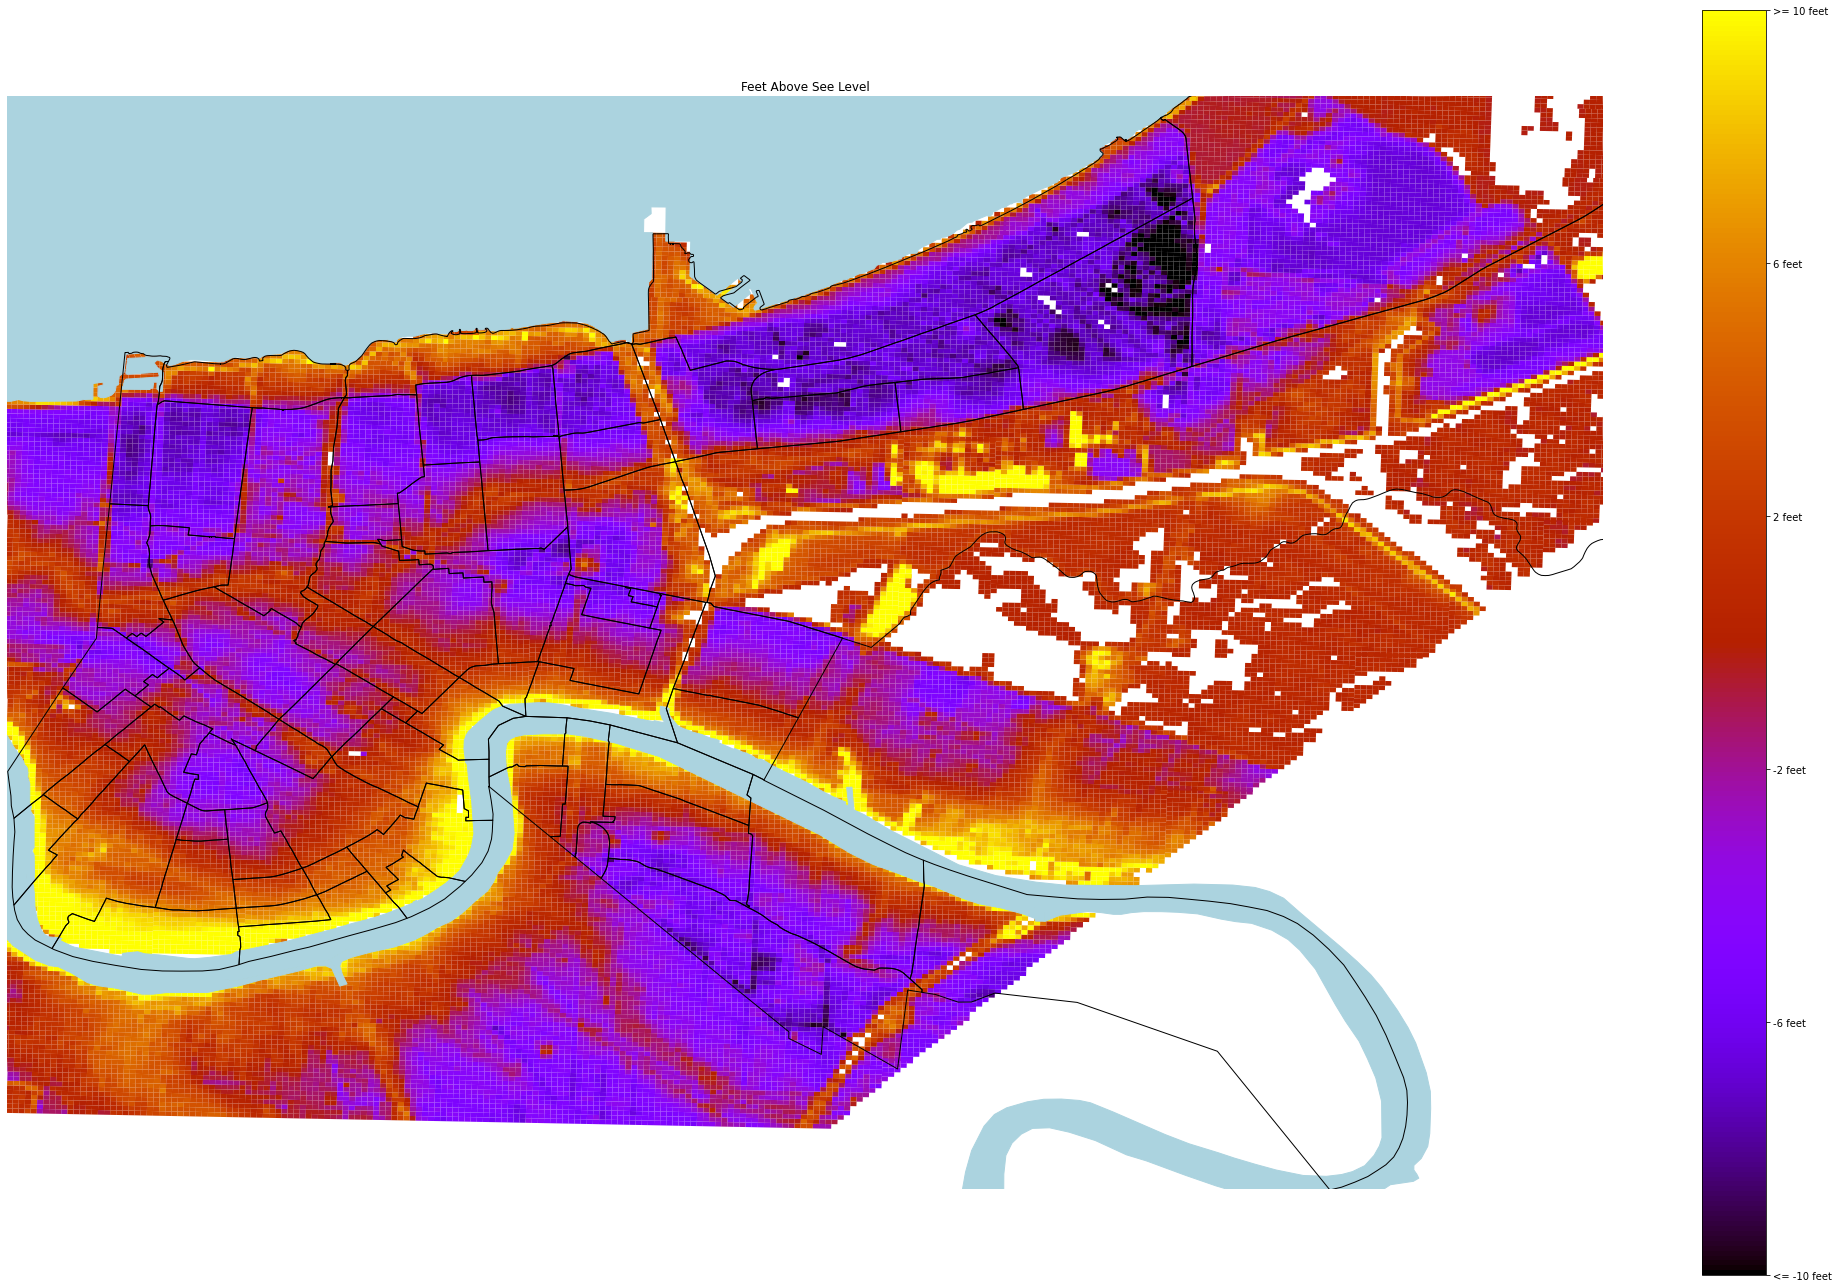

In [9]:
projection = gplt.LambertCylindrical()
fig, ax = plt.subplots(figsize=(28,18), subplot_kw={'projection': projection})

extent = (-90.14003111,  29.86560481, -89.87, 30.08)


gplt.choropleth(lasDf[groundMask],hue='elevationNorm', legend=True, ax=ax, projection=projection, zorder=20, extent=extent, cmap='gnuplot', edgecolor=(1,0,0,0))
gplt.polyplot(waterDf,ax=ax, projection=projection, edgecolor='#abd3df', facecolor='#abd3df', extent=extent, zorder=22)
gplt.polyplot(neighborhoodDf, edgecolor='black', facecolor=(1,0,0,0), projection=projection, ax=ax, extent=extent, zorder=23)

cbar = fig.get_axes()[-1]
labels = [str(int(x)) + ' feet' for x in norm.inverse(cbar.get_yticks())]
labels[0] = '<= -10 feet'
labels[-1] = '>= 10 feet'
cbar.set_yticklabels(labels)

ax.set_title('Feet Above See Level')
fig.tight_layout()


fig.savefig('NewOrleansElevation1.png')